In [2]:
pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25847 sha256=fc6cca6b381766c6d2bde3aa96ff45b4a0f1a4b8ef7c548162ee0bc3d0cc46c4
  Stored in directory: c:\users\kiit\appdata\local\pip\cache\wheels\4b\a5\2d\4a070a801d3a3d93f033d3ee9728f470f514826e89952df3ea
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [44]:
import numpy as np
import imutils
import cv2
import os
import matplotlib.pyplot as plt

In [43]:
path2 = r'F:\\Image panaroma\\images\\panaroma-1.jpg'
path1= r'F:\\Image panaroma\\images\\panaroma-2.jpg'

In [45]:
imageA = cv2.imread(path1)
imageA=cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)
imageB=cv2.imread(path2)
imageB=cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)

In [46]:
imageA_resize = cv2.resize(imageA, (780, 540),
               interpolation = cv2.INTER_LINEAR)

imageB_resize = cv2.resize(imageB, (780, 540),
               interpolation = cv2.INTER_LINEAR)

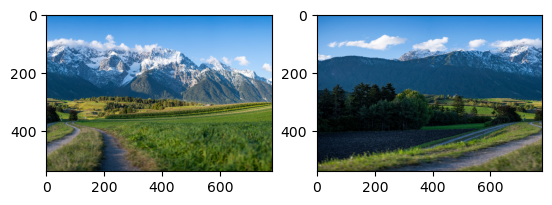

In [47]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(np.rot90(imageA_resize,4))
f.add_subplot(1,2, 2)
plt.imshow(np.rot90(imageB_resize,4))
plt.show(block=True)

In [48]:
def detectAndDescribe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # detect keypoints in the image
    descriptor = cv2.xfeatures2d.SIFT_create()
    (kps, features) = descriptor.detectAndCompute(gray, None)
    
    kps = np.float32([kp.pt for kp in kps])
    
    return (kps, features)
  
    
    

In [49]:
kpsA,featuresA =detectAndDescribe(imageA_resize)
print(kpsA.shape)
print (featuresA.shape)

(2752, 2)
(2752, 128)


In [50]:
kpsB,featuresB =detectAndDescribe(imageB_resize)
print(kpsB.shape)
print (featuresB.shape)

(1556, 2)
(1556, 128)


In [51]:
def matchKeypoints(kpsA, kpsB, featuresA, featuresB,ratio, reprojThresh):
    # compute the raw matches and initialize the list of actual
    # matches
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
    matches = []
    # loop over the raw matches
    for m in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    # computing a homography requires at least 4 matches
    if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])
        # compute the homography between the two sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,reprojThresh)
        # return the matches along with the homograpy matrix
        # and status of each matched point
    return (matches, H, status)
    # otherwise, no homograpy could be computed
    return None

In [52]:
ratio=0.75
reprojThresh=4.0
showMatches=False
M,H,status= matchKeypoints(kpsA, kpsB,featuresA, featuresB, ratio, reprojThresh)
print(M)
print (H)
print(status)

[(1248, 6), (1156, 20), (1157, 23), (1165, 31), (1167, 34), (1168, 36), (1171, 38), (1173, 40), (1176, 43), (1182, 44), (1184, 50), (1190, 54), (1193, 55), (1203, 59), (1202, 61), (1201, 63), (1229, 66), (1212, 67), (1215, 68), (1219, 71), (1233, 79), (1238, 84), (1241, 87), (1242, 89), (1243, 90), (1247, 91), (1248, 92), (1252, 97), (1255, 100), (1269, 101), (1270, 102), (1258, 110), (1268, 113), (1271, 114), (1279, 116), (1276, 117), (1281, 123), (1280, 126), (1290, 127), (1295, 129), (1302, 131), (1303, 133), (1304, 134), (1307, 136), (1306, 138), (1312, 145), (1293, 150), (1333, 161), (1336, 166), (1355, 174), (1357, 175), (1362, 177), (1366, 178), (1364, 181), (1368, 184), (1380, 192), (1382, 195), (1384, 198), (1387, 206), (1410, 214), (1406, 215), (1422, 221), (1423, 222), (1432, 228), (1430, 229), (1434, 233), (1442, 239), (1441, 240), (1455, 246), (1462, 249), (1464, 250), (1469, 252), (1480, 259), (1473, 261), (1471, 263), (1477, 264), (1475, 265), (1498, 276), (1502, 277), (

In [53]:
result = cv2.warpPerspective(imageA, H,(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

In [54]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB
    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
            # return the visualization
    return vis

In [55]:
matches=M
vis = drawMatches(imageA, imageB, kpsA, kpsB, matches,status)

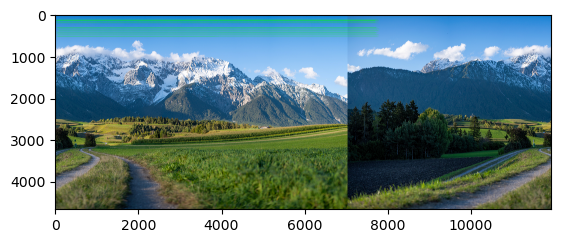

In [56]:
plt.imshow(vis)
plt.show()

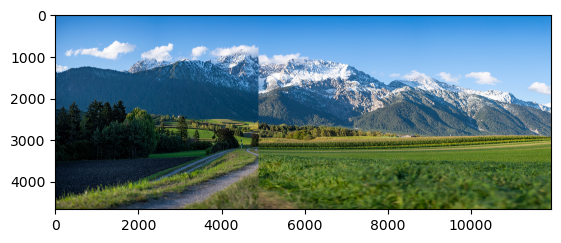

In [57]:
plt.imshow(result)
plt.show()